# Plot Figure 11: Bar chart

In [1]:
# datasets/analysis
import numpy as np
import xarray as xr
from glob import glob

# cosima
import cosima_cookbook as cc

# plotting
import matplotlib.pyplot as plt
# import matplotlib.path as mpath
# from matplotlib.lines import Line2D
# import matplotlib.patches as mpatches
import cmocean.cm as cmo

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34353/status,
Dashboard: /proxy/34353/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39227,Workers: 7
Dashboard: /proxy/34353/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:37185,Total threads: 4
Dashboard: /proxy/46873/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:46011,


Define the databases containing the experiments. 

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for ssp585_wind_thermal simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

### Read in data for the DSW formation metric

In [4]:
def get_SWMT(outpath, expt, time_bounds):

    net_transformation = xr.open_dataset(outpath + f'/SWMT_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + f'/HT_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + f'/ST_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map
    
def antarctic_SWMT_sum(outpath, expt, session, time_bounds):
    #outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT_temp/'
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1) 
    swmt, heat, salt = get_SWMT(outpath, expt, time_bounds)
    
    ## sum over region, convert to Sv
    isopycnal_bin_mid = swmt.isopycnal_bins
    # restrict to Antarctic shelf
    swmt_shelf, shelf_mask = shelf_mask_isobath(swmt)
    heat_shelf, shelf_mask = shelf_mask_isobath(heat)
    salt_shelf, shelf_mask = shelf_mask_isobath(salt)
    area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
    swmt_shelf_sum = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()#values
    heat_shelf_sum = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()#values
    salt_shelf_sum = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()#values

    return swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum, isopycnal_bin_mid

In [5]:
outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/'
time_bounds = '2160_1-2164_12'
time_bounds_2 = '2160_1-2160_12'
dsw_form = np.zeros(5)
colours = ['k','#92c5de', '#0571b0','#fdae61','#ca0020']
plt.figure(figsize=(6,8))

expts = [control, ssp245, ssp245mw, ssp585, ssp585mw]
for i, expt in enumerate(expts): 
    if expt == control:
        print('control')
        swmt, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath, expt, master_session, time_bounds)
        argmax = swmt.argmax()
        max = swmt[argmax].values
        arg30 = (argmax + (abs(swmt.isel(isopycnal_bins = slice(argmax.values,None)) - max*0.3)).argmin()).values
        arg70 = (argmax + (abs(swmt.isel(isopycnal_bins = slice(argmax.values,None)) - max*0.7)).argmin()).values
        print(argmax.values, max, arg70, arg30)
    else:
        swmt, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath, expt, expt_session, time_bounds)

    plt.plot(swmt, swmt.isopycnal_bins, c=colours[i])
    plt.scatter(swmt[argmax],swmt.isopycnal_bins[argmax], c=colours[i], marker='o')
    plt.scatter(swmt[arg70], swmt.isopycnal_bins[arg70],c=colours[i], marker='s')
    plt.scatter(swmt[arg30], swmt.isopycnal_bins[arg30],c=colours[i], marker='d')
    
    dsw_form[i] = swmt.isel(isopycnal_bins=slice(arg70, arg30)).mean().values

plt.gca().invert_yaxis()
plt.close()

control
71 8.67433443051777 82 94


### Read in data for the DSW export metric

In [6]:
ti = '2150-01-01'
tf = '2164-12-31'
slev_ssp245 = cc.querying.getvar(ssp245, 'sea_level', expt_session, start_time=ti, end_time=tf).sel(time=slice(ti, tf), yt_ocean=slice(None, -58))
slev_ssp245.time

ti = '2150-01-01'
tf = '2160-06-30'
slev_cntl = cc.querying.getvar(control, 'sea_level', master_session, start_time=ti, end_time=tf).sel(time=slice(ti, tf), yt_ocean=slice(None, -58))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [7]:
def read_cross_shelf_transport(path, first_file, time_array):
    '''
    path: array of directory paths to monthly files containing cross-shelf volume transport data
    first_file: full path to first month (2150_01) of cross-shelf volume transport data
    '''
    
    vol_transp = xr.open_dataset(first_file)
    
    for i in range(1, len(path)):
        vol_transp = xr.concat([vol_transp, xr.open_dataset(path[i])], dim = 'time')

    vol_transp['time'] = time_array['time'].values
    vol_transp_total = (vol_transp['vol_trans_across_contour_binned']*vol_transp['ndays']).sum('time')/np.sum(vol_transp['ndays'])
    
    return vol_transp, vol_transp_total

In [8]:
# Control 
path_ctrl = np.sort(glob('/g/data/g40/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/*'))
file_ctrl = '/g/data/g40/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc'
time_array = slev_cntl
vol_transp_ctrl, vol_transp_ctrl_total = read_cross_shelf_transport(path_ctrl, file_ctrl, time_array)

In [9]:
# Experiments
# SSP245
path_ssp245 = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245/*'))
file_ssp245 = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245/vol_trans_across_contour_2150_01_sigma1.nc'
time_array = slev_ssp245
vol_transp_ssp245, vol_transp_ssp245_total = read_cross_shelf_transport(path_ssp245, file_ssp245, time_array)

# SSP245 MW
path_ssp245mw = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245_mw/*'))
file_ssp245mw = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245_mw/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp245mw, vol_transp_ssp245mw_total = read_cross_shelf_transport(path_ssp245mw, file_ssp245mw, time_array)

# SSP585
path_ssp585 = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585/*'))
file_ssp585 = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp585, vol_transp_ssp585_total = read_cross_shelf_transport(path_ssp585, file_ssp585, time_array)

# SSP585 MW
path_ssp585mw = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585_mw/*'))
file_ssp585mw = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585_mw/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp585mw, vol_transp_ssp585mw_total = read_cross_shelf_transport(path_ssp585mw, file_ssp585mw, time_array)

Calculate time-mean offshore transport

In [10]:
# sum transport along the 1000 m isobath
net_offshore_trans_control = vol_transp_ctrl['vol_trans_across_contour_binned'].sum('contour_index')
net_offshore_trans_ssp245 = vol_transp_ssp245['vol_trans_across_contour_binned'].sum('contour_index')
net_offshore_trans_ssp245mw = vol_transp_ssp245mw['vol_trans_across_contour_binned'].sum('contour_index')
net_offshore_trans_ssp585 = vol_transp_ssp585['vol_trans_across_contour_binned'].sum('contour_index')
net_offshore_trans_ssp585mw = vol_transp_ssp585mw['vol_trans_across_contour_binned'].sum('contour_index')

## cumsum transport from the bottom (upwards from densest isopycnals) and convert to Sverdrups
psi_ctrl_tv = net_offshore_trans_control[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
psi_ssp245_tv = net_offshore_trans_ssp245[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
psi_ssp245mw_tv = net_offshore_trans_ssp245mw[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
psi_ssp585_tv = net_offshore_trans_ssp585[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
psi_ssp585mw_tv = net_offshore_trans_ssp585mw[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6

## take mean in time
ti = '2160-01-01'
tf = '2164-12-31'

# for control take mean over first 10 years (last 5 years of cross-shelf transport are not available)
mean_ctrl_tv = psi_ctrl_tv.mean('time')

# for experiments take mean over last 5 years
mean_ssp245_tv = psi_ssp245_tv.sel(time=slice(ti, tf)).mean('time')
mean_ssp245mw_tv = psi_ssp245mw_tv.sel(time=slice(ti, tf)).mean('time')
mean_ssp585_tv = psi_ssp585_tv.sel(time=slice(ti, tf)).mean('time')
mean_ssp585mw_tv = psi_ssp585mw_tv.sel(time=slice(ti, tf)).mean('time')

argmax = mean_ctrl_tv.argmax()
max = mean_ctrl_tv[argmax].values
arg30 = (argmax + (abs(mean_ctrl_tv.isel(isopycnal_bins = slice(argmax.values,None)) - max*0.3)).argmin()).values
arg70 = (argmax + (abs(mean_ctrl_tv.isel(isopycnal_bins = slice(argmax.values,None)) - max*0.7)).argmin()).values
print(argmax.values, max, mean_ctrl_tv[argmax].isopycnal_bins.item(), arg70, arg30)

107 8.533531646788651 32.55999999999989 110 114


In [11]:
dsw_expt = np.zeros(5)
colours = ['k','#92c5de', '#0571b0','#fdae61','#ca0020']

dsw_expt[0] = mean_ctrl_tv.isel(isopycnal_bins = int(argmax))
dsw_expt[1] = mean_ssp245_tv.isel(isopycnal_bins = int(argmax))
dsw_expt[2] = mean_ssp245mw_tv.isel(isopycnal_bins = int(argmax))
dsw_expt[3] = mean_ssp585_tv.isel(isopycnal_bins = int(argmax))
dsw_expt[4] = mean_ssp585mw_tv.isel(isopycnal_bins = int(argmax))
# dsw_expt

### Calculate sea ice extent

Load time series data

In [12]:
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/seaice_timeseries/'
ds_ctrl = xr.open_dataset(outdir + 'control_timeseries.nc').get('aice').load()
print("loading ssp245 sea ice data")
ds_ssp245 = xr.open_dataset(outdir + 'ssp245_timeseries.nc').get('aice').load()
print("loading ssp245mw sea ice data")
ds_ssp245mw = xr.open_dataset(outdir + 'ssp245mw_timeseries.nc').get('aice').load()
print("loading ssp585 sea ice data")
ds_ssp585 = xr.open_dataset(outdir + 'ssp585_timeseries.nc').get('aice').load()
print("loading ssp585mw sea ice data")
ds_ssp585mw = xr.open_dataset(outdir + 'ssp585mw_timeseries.nc').get('aice').load()

loading ssp245 sea ice data
loading ssp245mw sea ice data
loading ssp585 sea ice data
loading ssp585mw sea ice data


Define function to calculate extent

In [13]:
def calculate_extent(concentration, area_t):
    extent = xr.where(concentration >= 0.15, area_t, 0.).sum('xt_ocean').sum('yt_ocean')
    return extent

# Get grid info
lat_slice = slice(-85,-50)
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)
area_t_so = area_t.sel(yt_ocean=lat_slice)

Calculate sea ice extent

In [14]:
extent_ctrl = calculate_extent(ds_ctrl, area_t_so).compute()
extent_ssp245 = calculate_extent(ds_ssp245, area_t_so).compute()
extent_ssp245mw = calculate_extent(ds_ssp245mw, area_t_so).compute()
extent_ssp585 = calculate_extent(ds_ssp585, area_t_so).compute()
extent_ssp585mw = calculate_extent(ds_ssp585mw, area_t_so).compute()

Now calculate the monthly climatology averaged over the last 5 years of the experiment. 

In [15]:
ti='2160-01-01'
tf='2164-12-31'
monthly_extent_ctrl = extent_ctrl.sel(time=slice(ti, tf)).groupby('time.month').mean(dim='time')
monthly_extent_ssp245 = extent_ssp245.sel(time=slice(ti, tf)).groupby('time.month').mean(dim='time')
monthly_extent_ssp245mw = extent_ssp245mw.sel(time=slice(ti, tf)).groupby('time.month').mean(dim='time')
monthly_extent_ssp585= extent_ssp585.sel(time=slice(ti, tf)).groupby('time.month').mean(dim='time')
monthly_extent_ssp585mw = extent_ssp585mw.sel(time=slice(ti, tf)).groupby('time.month').mean(dim='time')
monthly_extent_ctrl.sel(month=2).values

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


array(1.2350378e+12, dtype=float32)

In [16]:
sie_feb = np.zeros(5)
sie_feb[0] = monthly_extent_ctrl.sel(month=2).values
sie_feb[1] = monthly_extent_ssp245.sel(month=2).values
sie_feb[2] = monthly_extent_ssp245mw.sel(month=2).values
sie_feb[3] = monthly_extent_ssp585.sel(month=2).values
sie_feb[4] = monthly_extent_ssp585mw.sel(month=2).values

sie_sep = np.zeros(5)
sie_sep[0] = monthly_extent_ctrl.sel(month=9).values
sie_sep[1] = monthly_extent_ssp245.sel(month=9).values
sie_sep[2] = monthly_extent_ssp245mw.sel(month=9).values
sie_sep[3] = monthly_extent_ssp585.sel(month=9).values
sie_sep[4] = monthly_extent_ssp585mw.sel(month=9).values
# sie_sep

### Read in ASC along-slope speed changes

In [17]:
asc_spd_change = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/along_shelf_transport/asc_speed_changes.nc')
asc_spd_change = asc_spd_change.spd_percent_change
asc_spd_change

<xarray.DataArray 'spd_percent_change' (experiment: 4)> Size: 32B
[4 values with dtype=float64]
Coordinates:
  * experiment  (experiment) <U8 128B 'ssp245' 'ssp245mw' 'ssp585' 'ssp585mw'
Attributes:
    depth_range:  0 - 1000 m
    slope_range:  1000 m isobath to 2500 m isobath
    definition:   Change (%) in upper-ocean along-slope speed compared to the...

### Read in shelf temperature data and calculate anomaly

Read in timeseries which contains volume-averaged temperature over the continental shelf for the whole length of the simulations. 

In [18]:
start_time = '2150-01-01'
end_time = '2164-12-31'
datadir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_timeseries/'

cntl = xr.open_dataset(datadir + f'whole_shelf_control_{start_time}-{end_time}.nc')
ssp245 = xr.open_dataset(datadir + f'whole_shelf_ssp245_{start_time}-{end_time}.nc')
ssp245mw = xr.open_dataset(datadir + f'whole_shelf_ssp245mw_{start_time}-{end_time}.nc')
ssp585 = xr.open_dataset(datadir + f'whole_shelf_ssp585_{start_time}-{end_time}.nc')
ssp585mw = xr.open_dataset(datadir + f'whole_shelf_ssp585mw_{start_time}-{end_time}.nc')

Calculate time-averaged temperature anomalies across the last 5 years of the experiments. 

In [19]:
ti = '2160-01-01'
tf = '2164-12-31'

temp_anom = np.zeros(4)
temp_anom[0] = (ssp245.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.mean()
temp_anom[1] = (ssp245mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.mean()
temp_anom[2] = (ssp585.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.mean()
temp_anom[3] = (ssp585mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.mean()

temp_anom_std = np.zeros(4)
temp_anom_std[0] = (ssp245.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.std()
temp_anom_std[1] = (ssp245mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.std()
temp_anom_std[2] = (ssp585.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.std()
temp_anom_std[3] = (ssp585mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).temp.std()

print(np.round(temp_anom[0], decimals=2), np.round(temp_anom[1], decimals=2),
      np.round(temp_anom[2], decimals=2), np.round(temp_anom[3], decimals=2), )

0.1 0.11 0.2 0.52


### Read in shelf salinity and calculate anomaly

Read in timeseries which contains volume-averaged salinity over the continental shelf for the whole length of the simulations. 

In [20]:
start_time = '2150-01-01'
end_time = '2164-12-31'
datadir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_timeseries/'

cntl = xr.open_dataset(datadir + f'whole_shelf_control_{start_time}-{end_time}.nc')
ssp245 = xr.open_dataset(datadir + f'whole_shelf_ssp245_{start_time}-{end_time}.nc')
ssp245mw = xr.open_dataset(datadir + f'whole_shelf_ssp245mw_{start_time}-{end_time}.nc')
ssp585 = xr.open_dataset(datadir + f'whole_shelf_ssp585_{start_time}-{end_time}.nc')
ssp585mw = xr.open_dataset(datadir + f'whole_shelf_ssp585mw_{start_time}-{end_time}.nc')

Calculate time-averaged salinity anomalies across the last 5 years of the experiments. 

In [21]:
ti = '2160-01-01'
tf = '2164-12-31'

salt_anom = np.zeros(4)
salt_anom[0] = (ssp245.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.mean()
salt_anom[1] = (ssp245mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.mean()
salt_anom[2] = (ssp585.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.mean()
salt_anom[3] = (ssp585mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.mean()

salt_anom_std = np.zeros(4)
salt_anom_std[0] = (ssp245.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.std()
salt_anom_std[1] = (ssp245mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.std()
salt_anom_std[2] = (ssp585.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.std()
salt_anom_std[3] = (ssp585mw.sel(time=slice(ti,tf)) - cntl.sel(time=slice(ti,tf))).salt.std()

print(np.round(salt_anom[0], decimals=2), np.round(salt_anom[1], decimals=2),
      np.round(salt_anom[2], decimals=2), np.round(salt_anom[3], decimals=2), )

-0.04 -0.17 -0.1 -0.68


### Finally, plot bar chart

Define diagnostic labels. 

In [22]:
diags_1 = ("DSW$_{form}$","DSW$_{expt}$","SIE$_{Feb}$","SIE$_{Sep}$","ASC$_{spd}$")
diags_2 = ["$\Delta$ T$_{shelf}$"]
diags_3 = ["$\Delta$ S$_{shelf}$"]

Convert DSW formation, export and SIE values to percent change from the control simulation. 

In [23]:
dsw_form_pct = (dsw_form)/dsw_form[0]*100
dsw_expt_pct = (dsw_expt)/dsw_expt[0]*100
sie_feb_pct = (sie_feb)/sie_feb[0]*100
sie_sep_pct = (sie_sep)/sie_sep[0]*100

In [24]:
bar_chart_vals = {'SSP245':    (dsw_form_pct[1], dsw_expt_pct[1], sie_feb_pct[1], 
                                sie_sep_pct[1], asc_spd_change[0], ),
                  'SSP245 MW':   (dsw_form_pct[2], dsw_expt_pct[2], sie_feb_pct[2], 
                                  sie_sep_pct[2], asc_spd_change[1], ),
                  'SSP585':      (dsw_form_pct[3], dsw_expt_pct[3], sie_feb_pct[3], 
                                  sie_sep_pct[3], asc_spd_change[2], ),
                  'SSP585 MW':   (dsw_form_pct[4], dsw_expt_pct[4], sie_feb_pct[4], 
                                  sie_sep_pct[4], asc_spd_change[3], ),
                 }

# Temp and salt anomaly values
temp_vals = {'SSP245':    (temp_anom[0]), 'SSP245 MW':   (temp_anom[1]),
               'SSP585':      (temp_anom[2]), 'SSP585 MW':   (temp_anom[3]),  }
salt_vals = {'SSP245':    (salt_anom[0]), 'SSP245 MW':   (salt_anom[1]),
             'SSP585':      (salt_anom[2]), 'SSP585 MW':   (salt_anom[3]),   }

# Tempa and salt standard deviation
temp_std = {'SSP245':     (temp_anom_std[0]), 'SSP245 MW':   (temp_anom_std[1]),
            'SSP585':      (temp_anom_std[2]), 'SSP585 MW':   (temp_anom_std[3]),  }
salt_std = {'SSP245':     (salt_anom_std[0]), 'SSP245 MW':   (salt_anom_std[1]),
            'SSP585':      (salt_anom_std[2]), 'SSP585 MW':   (salt_anom_std[3]),  }

In [25]:
def figure_setup():

    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(ncols=4, figsize=(14,5), width_ratios=[5,1,0.5, 1])
    plt.subplots_adjust(wspace=0.04)
    for i, ax in enumerate(axes[1:].flatten()):
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    axes[2].axis('off') 
    axes[1].spines['left'].set_color('k')
    axes[0].grid(axis='y', ls='--')
    axes[1].grid(axis='y', ls='--')
    axes[3].grid(axis='y', ls='--')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axes[0].set_ylabel('% of CONTROL')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axes[1].set_ylabel('Temperature anomaly (\u00b0C)')
    axes[3].set_ylabel('Salinity anomaly (g/kg)')
    axes[1].set_xlim([-0.35,0.35])
    axes[3].set_xlim([-0.35,0.35])
    axes[1].set_ylim([-0, 0.6])
    axes[0].set_ylim([0, 300])


    return fig, axes

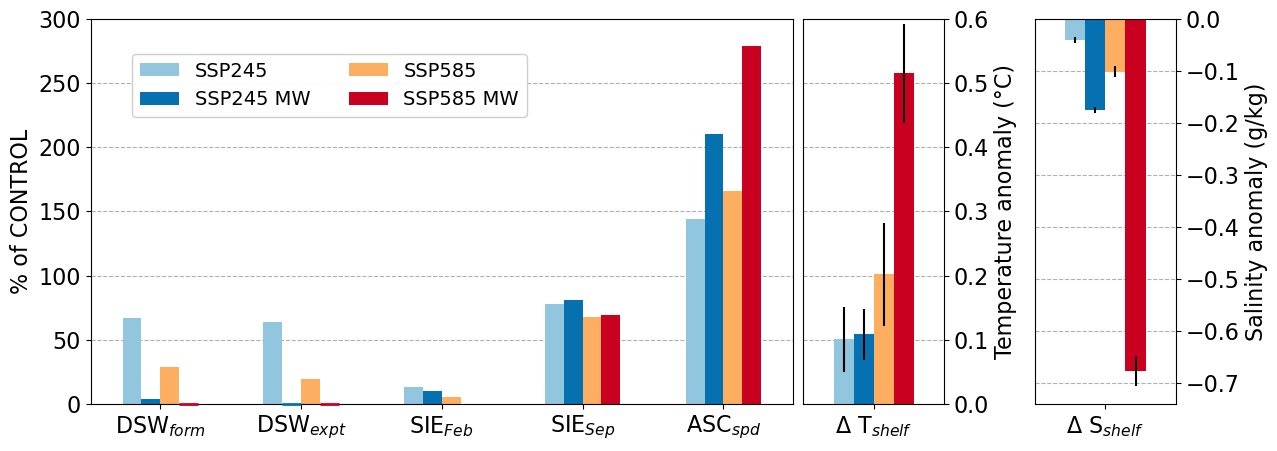

In [38]:
fig, axes = figure_setup()

x = np.arange(1,4.5,0.75) # the label locations
width = 0.1  # the width of the bars
multiplier = -0.5
colours = ['#92c5de', '#0571b0', '#fdae61', '#ca0020']

# Percent changes
n = 0
for attribute, measurement in bar_chart_vals.items():
    offset = width * multiplier
    rects = axes[0].bar(x + offset, measurement, width, label=attribute, color=colours[n], zorder=2)
    multiplier += 1
    n += 1
axes[0].set_xticks(x + width, diags_1)


# Temperature anomalies
x = np.arange(1)  
width = 0.1  
multiplier = -1.5
n = 0
for attribute, measurement in temp_vals.items():
    y_err = temp_std[attribute] # get standard deviation for expt
    offset = width * multiplier
    rects = axes[1].bar(x + offset, measurement, width, label=attribute,  yerr=y_err, 
                        color=colours[n], zorder=2)
    multiplier += 1
    n+=1
axes[1].set_xticks(x, diags_2)

# Salinity anomalies
x = np.arange(1)  
width = 0.1 
multiplier = -1.5
n = 0
for attribute, measurement in salt_vals.items():
    yerr = salt_std[attribute] # get standard deviation for expt
    offset = width * multiplier
    rects = axes[3].bar(x + offset, measurement, width, label=attribute, yerr=yerr, 
                        color=colours[n], zorder=2)
    multiplier += 1
    n+=1
axes[3].set_xticks(x, diags_3)
axes[3].set_xlim([-0.35,0.35])

# Add lines at zero for the relevant metrics
axes[0].hlines(0, 1.2, 1.3, color=colours[3], lw=2, zorder=4, alpha=1, clip_on=False)
axes[0].hlines(0, 1.75, 1.85, color=colours[1], lw=2, zorder=4, alpha=1, clip_on=False)
axes[0].hlines(0, 1.95, 2.05, color=colours[3], lw=2, zorder=4, alpha=1, clip_on=False)

plt.legend(ncols=2, bbox_to_anchor=[-3.55,0.935], fontsize=14, framealpha=0.95)

plt.savefig('/home/561/hd4873/project3/figs/Fig011_bar.jpg', dpi=300, bbox_inches='tight')

plt.show()